# Lab 3 - statistikk

## Vektdata
Etter labøvelsen burde du ha minst fem datasett med vekter over tid for de forskjellige syrekonsentrasjonene. For å kunne gjøre noe statistikk på datasettene må de først leses inn i variabler. I dette tilfellet er det *litt* mer komplisert siden LabView, programmet som skriver datafilen, bruker komma som desimaltegn i stedet for punktum. Under er det gitt et eksempel på hvordan man kan lese dataene inn i variabler. NumPy-funksjonen `genfromtxt` brukes (se forrige øvelse for mer informasjon) med den nye instillingen `usecols=(0,1)` som vil si at NumPy bare skal lese første og andre rad med data, den tredje er bare kommentarer.

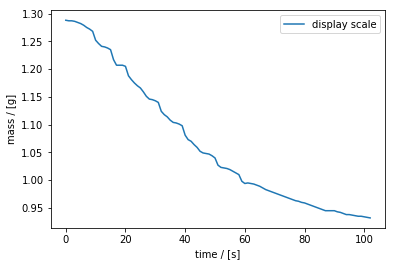

In [10]:
import numpy as np
from StringIO import StringIO

data = open('37C-400mMH+.lvm', 'r').read().replace(',', '.')
time, weight = np.genfromtxt(StringIO(data), skip_header=23, usecols=(0,1), unpack=True)

import matplotlib.pyplot as plt
plt.plot(time, weight, label='display scale')
plt.legend()
plt.xlabel('time / [s]')
plt.ylabel('mass / [g]')
plt.show()

## Masse $\mathrm{CO_2}$
Fra dataene du hentet ut over, lag en variabel med massen $\mathrm{CO_2}$ som er produsert og plott denne over tid.

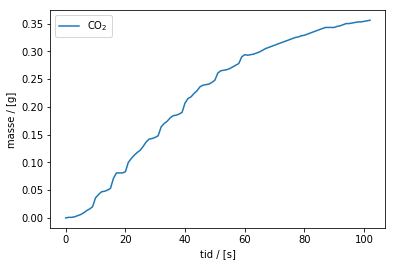

In [3]:
m_CO2 = weight[0]-weight
plt.plot(time, m_CO2, label='$\mathrm{CO_2}$')
plt.legend()
plt.xlabel('time / [s]')
plt.ylabel('mass / [g]')
plt.show()

## Starthastighet
Man kan bestemme reaksjonsordenen fra starthastighetene. Hastigheten er endringen i masse (eller stoffmengde) altså den deriverte. Men det er mye støy i målingene så man kan ikke si at starthastighten bare er differansen mellom de to første verdiene. Den enkleste løsningen er nok å bare regne den gjennomsnittlige stigningen over et litt større intervall.

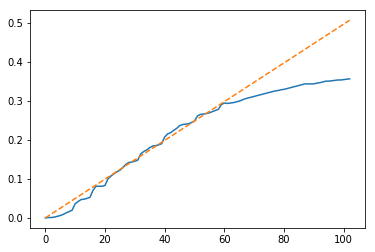

In [4]:
crop = 50
slope = m_CO2[crop] / time[crop]

plt.plot(time, m_CO2)
plt.plot(time, slope * time, '--')
plt.show()

En litt bedre metode er å bruke lineærregresjon på et lite intervall. SciPy har en statistikkmodul som gjør dette veldig lett.

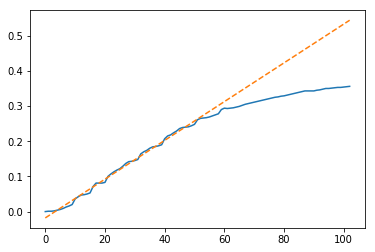

In [5]:
from scipy import stats
crop = 30
slope, intercept, r_value, p_value, std_err = stats.linregress(time[:crop], m_CO2[:crop])

def initial_rate_eqn(t):
    return intercept + t * slope

plt.plot(time, m_CO2)
plt.plot(time, initial_rate_eqn(time), '--')
plt.show()

En enda mer sofistikert metode er ikke-lineær regresjon. Dersom man *vet* hvilken form funksjonen skal kan man bruke minste kvadraters metode for å finne en tilpasning. Dersom det er en førsteordens reaksjon burde dataene anta den eksponentielle formen
$$\hat{m}_{\mathrm{CO_2}}=A\left(1-e^{-\lambda t}\right)$$
for to parametre $A$ og $\lambda$. $A$ er den maksimale mengden $\mathrm{CO_2}$ som kan bli produsert og $\lambda$ er relatert til hvor fort $\mathrm{CO_2}$ produseres.

Starthastigheten er da gitt ved $k_0 = A\lambda$. 

SciPy har en modul kalt `optimize` som kan gjøre kurvetilpasning. Under er det et eksempel der denne eksponentielle kurven tilpasses måledataene. Legg merke til at det er lagt til en kostant `eps` i uttrykket fordi nullpunktet i dataene ikke nødvendigvis er det faktiske nullpunktet på grunn av støy.

<div class="alert alert-danger">
Legg merke til at man ikke kan bruke variabelnavnet `lambda` for $\lambda$ i Python. `lambda` brukes til å definiere såkalte lambdafunksjoner som er en rask måte å skrive små funksjoner på. For å definere $f(x) = x^2$ kan man skrive `f = lambda x: x**2`.
</div>

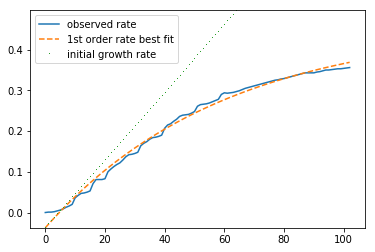

In [6]:
def first_order(t, l, A, eps):
    return A * (1 - np.exp(-l*t)) + eps

from scipy.optimize import curve_fit
opt_params, opt_params_cov = curve_fit(first_order, time, m_CO2)
l, A, eps = opt_params

plt.plot(time, m_CO2, label='observed rate')
plt.plot(time, first_order(time, l, A, eps), '--', label='1st order rate best fit')
plt.plot(time, l*time*A+eps, ',', label='initial growth rate')
plt.legend()
plt.ylim((min(eps, 0), A))
plt.show()

Velg en av metodene over for å bestemme starthastighet (eller gjør det på din egen måte) på alle reaksjonene du utførte.


## Reaksjonsorden
Reaksjonshastigheten når $\mathrm{H^+}$ og $\mathrm{HCO_3^-}$ reagerer kan generelt skrives 
$$R=\frac{\mathrm{d}}{\mathrm{d}t}\mathrm{[CO_2]} = [\mathrm{H^+}]^n[\mathrm{HCO_3^-}]^m$$
så ved tid $t=0$ er hastigheten avhengig av startkonsentrasjonene av $\mathrm{H^+}$ og $\mathrm{HCO_3^-}$. Tar man logaritmen på begge sider får man
$$\begin{align*}
\ln\left(\frac{\mathrm{d}}{\mathrm{d}t}\mathrm{[CO_2]_0}\right) &= \ln\left([\mathrm{H^+}]_0^n[\mathrm{HCO_3^-}]_0^m\right)\\
&= n\ln[\mathrm{H^+}]_0 + m\ln[\mathrm{HCO_3^-}]\\
&= a\ln[\mathrm{H^+}]_0 + b.
\end{align*}$$
Dette er en lineær likning som man kan finne ved lineærregresjon der stigningen, $a$, er reaksjonsordenen, $n$, og skjæringspunktet, $b$, er bidraget til reaksjonshastigeten fra $\mathrm{HCO_3^-}$.

Bestem reaksjonsordenen med hensyn på $\mathrm{H^+}$ fra starthastighetene ved å bruke lineærregresjon.